<a href="https://colab.research.google.com/github/AryanChaturvedi/Text-Classification/blob/main/Tf_Idf_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag

####	Dataset Used:  
- IITJEE NEET AIIMS Students Questions Data
-- The dataset contains Students-questions.csv file in version 1 as of now.
Inside the CSV file, we have two columns:

- eng: The full question or description of the questions

- Subject: Which subject does the question belong to. It has 4 classes, Physics, Chemistry, Biology, and Mathematics.


So, it's basically an NLP problem where we have the question description, and we need to find out which subject does this question belongs to.

Link To dataset: https://www.kaggle.com/datasets/mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

The dataset contains total 120000+ questions from which I have sampled 10000 questions.


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Opencv/Document Classification/subjects-questions_10000.csv')

In [4]:
train

,Unnamed: 0,eng,Subject
0,95298,First discovered enzyme was\nA. Isomerase\nB. ...,Biology
1,55186,The diagram shows two magnets and\ntwo iron ro...,Physics
2,111545,Polynuclear hydrocarbons are formed by complet...,Chemistry
3,34588,A turn of radius \( 20 \mathrm{m} \) is banked...,Physics
4,105967,In an equilateral triangle of side \( 3 \sqrt{...,Maths
...,...,...,...
9995,1551,Prove that \( (1+i)^{4}\left(1+\frac{1}{i}\rig...,Maths
9996,77283,Find inclination (in degrees) of a line perpen...,Maths
9997,118940,Burning of coal and diseal releases:\nThis que...,Chemistry
9998,6668,An LCR series circuit with \( 100 \Omega \)\nr...,Physics


### EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   eng         10000 non-null  object
 2   Subject     10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [6]:
# Distribution of Questions per subject
train.groupby('Subject').count()

,Unnamed: 0,eng
Subject,,
Biology,1065,1065
Chemistry,3114,3114
Maths,2702,2702
Physics,3119,3119


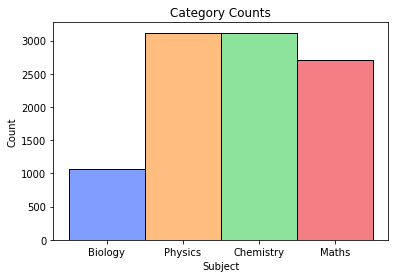

In [7]:
fig, ax = plt.subplots()
sns.histplot(
    data = train,
    x = 'Subject',
    hue = 'Subject',
    palette = 'bright',
    legend = False,
    ).set(
        title = 'Category Counts');

In [8]:
# No of words per questions
train['word_count'] = train['eng'].apply(lambda row : len(row.split()))
train

,Unnamed: 0,eng,Subject,word_count
0,95298,First discovered enzyme was\nA. Isomerase\nB. ...,Biology,12
1,55186,The diagram shows two magnets and\ntwo iron ro...,Physics,92
2,111545,Polynuclear hydrocarbons are formed by complet...,Chemistry,14
3,34588,A turn of radius \( 20 \mathrm{m} \) is banked...,Physics,52
4,105967,In an equilateral triangle of side \( 3 \sqrt{...,Maths,16
...,...,...,...,...
9995,1551,Prove that \( (1+i)^{4}\left(1+\frac{1}{i}\rig...,Maths,5
9996,77283,Find inclination (in degrees) of a line perpen...,Maths,10
9997,118940,Burning of coal and diseal releases:\nThis que...,Chemistry,33
9998,6668,An LCR series circuit with \( 100 \Omega \)\nr...,Physics,89


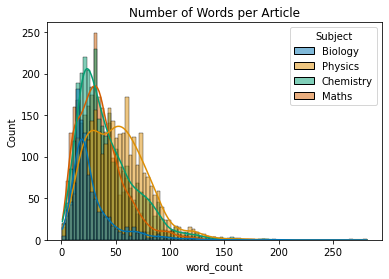

In [9]:
fig, ax = plt.subplots()
sns.histplot(
    data = train, 
    x = 'word_count',
    palette = 'colorblind',
    hue = 'Subject',
    kde = True
    ).set(
        title = 'Number of Words per Article');

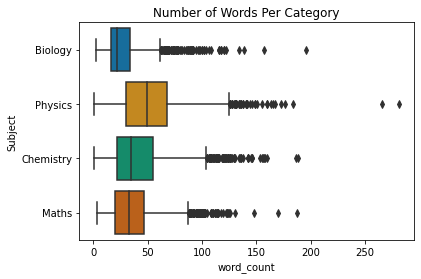

In [10]:
# Checking outliers for words per wustions per subject
fig, ax = plt.subplots()
sns.boxplot(
    data = train, 
    x = 'word_count', 
    y = 'Subject',
    palette = 'colorblind'
    ).set(
        title = 'Number of Words Per Category');

- Questions contains lots of symbols and non alphabatical charectors.

In [12]:
train['eng'].sample(1).values

array(['A red LED emits light at0.1 watt uniformly around it. The amplitude of the electric field of the light at a\ndistance of \\( 1 \\mathrm{m} \\) from the diode is :\n\\( \\mathbf{A} \\cdot 6 V / m \\)\nв. \\( 2.45 V / m \\)\nc. \\( 5.48 V / m \\)\nD. \\( 1.73 V / m \\)'],
      dtype=object)

- Define a function to remove special charectors and clean the text.

In [13]:
def clean(df):

    df.loc[:,'eng']=pd.DataFrame(df.loc[:,'eng'].str.lower())
    
    # remove (0-9) digits from a string
    df.loc[:,'eng'] = [re.sub(r'\d+','', i) for i in df.loc[:,'eng']]
    
    # [^a-zA-Z] means any character that IS NOT a-z OR A-Z, " " mans replace with space
    df.loc[:,'eng'] = [re.sub(r'[^a-zA-Z]',' ', i) for i in df.loc[:,'eng']]
    
    # remove single charector (alphabates)
    df.loc[:,'eng'] = [re.sub(r"\b[a-zA-Z]\b", '', i) for i in df.loc[:,'eng']]
    #remove special symbols
    df.loc[:,'eng'] = [re.sub(r"[#|\.|_|\^|\$|\&|=|;|,|‐|-|–|(|)|//|\\+|\|*|\']+",'', i) for i in df.loc[:,'eng']]
    
    # remove urls
    df.loc[:,'eng'] = [re.sub(r"https?://\S+|www\.\S+",' ', i) for i in df.loc[:,'eng']]
    
    # remove html tags
    df.loc[:,'eng'] = [re.sub(r"'<.*?>'",' ', i) for i in df.loc[:,'eng']]
    
    
    # remove extra whitespace
    df.loc[:,'eng'] = [re.sub('  +',' ', i) for i in df.loc[:,'eng']]
    
    
    return(df)

In [14]:
# Clean text
train = clean(train)

- Basic NLTK Preprocessing

In [15]:
def pre_process(text):
    #lowercasing
    text = text.lower()
    
    # Stemming
    porter = PorterStemmer()
    text = [porter.stem(word) for word in text.split()]
    text = " ".join(text)
    
    # Lemmatization
    lm = WordNetLemmatizer()
    text = [lm.lemmatize(word) for word in text.split()]
    
    
    # Remove stopwords
    stopword = stopwords.words('english')
    text =  [word for word in text if word not in stopword]
    text = " ".join(text)
    
    
    return text

In [16]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download("all")

In [18]:
# apply text preprocessing
train['Text_Processed'] = train['eng'].apply(lambda row : pre_process(row))

#### TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
v = TfidfVectorizer()
x = v.fit_transform(train['Text_Processed'])
x = x.toarray()
tf_idf = pd.DataFrame(x,columns = v.get_feature_names_out() )

In [21]:
tf_idf

,aa,aafer,aalapat,ab,aba,abandon,abbrevi,abc,abcd,abcdef,...,zwitter,zwitterion,zygapophys,zygomorph,zygomycet,zygospor,zygot,zygoten,zymas,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.409799,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [22]:
# Import models
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score,f1_score

In [23]:
# Convert Subject into classes
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(train['Subject'])

In [24]:
tags= label_encoder.classes_
tags

array(['Biology', 'Chemistry', 'Maths', 'Physics'], dtype=object)

In [25]:
# Train test split the dataset
X_train, X_test, y_train, y_test = train_test_split(tf_idf, labels, test_size = 0.2, random_state = 42)

In [26]:
#create Multinomial Naive Bayes model
classifier = MultinomialNB();
classifier.fit(X_train, y_train)

MultinomialNB()

In [27]:
# predicting test set results
y_pred = classifier.predict(X_test)

In [28]:
# Print classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.53      0.68       196
           1       0.80      0.90      0.85       601
           2       0.89      0.91      0.90       558
           3       0.86      0.88      0.87       645

    accuracy                           0.86      2000
   macro avg       0.88      0.80      0.83      2000
weighted avg       0.86      0.86      0.85      2000



#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest model
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=30,
                                       n_estimators=250, oob_score=True)
# Train the model
classifier_rf.fit(X_train,y_train)

# Predict and get accuracy
y_pred  =classifier_rf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.774


In [30]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.14      0.24       196
           1       0.62      0.91      0.74       601
           2       0.90      0.85      0.88       558
           3       0.89      0.77      0.83       645

    accuracy                           0.77      2000
   macro avg       0.84      0.67      0.67      2000
weighted avg       0.82      0.77      0.76      2000



### SVM

In [31]:
from sklearn.svm import SVC
reg_svc = SVC()
reg_svc.fit(X_train, y_train)
y_pred = reg_svc.predict(X_test)


In [32]:
print(metrics.classification_report(y_test, y_pred,target_names=tags))

              precision    recall  f1-score   support

     Biology       0.89      0.80      0.84       196
   Chemistry       0.81      0.91      0.86       601
       Maths       0.94      0.93      0.93       558
     Physics       0.92      0.85      0.88       645

    accuracy                           0.89      2000
   macro avg       0.89      0.87      0.88      2000
weighted avg       0.89      0.89      0.89      2000



### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)
y_pred = reg_log.predict(X_test)
print(metrics.classification_report(y_test, y_pred,target_names=tags))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

     Biology       0.86      0.81      0.83       196
   Chemistry       0.82      0.90      0.86       601
       Maths       0.92      0.93      0.93       558
     Physics       0.91      0.83      0.87       645

    accuracy                           0.88      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.88      0.88      2000



### KNN Classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
reg_knn = KNeighborsClassifier()
reg_knn.fit(X_train, y_train)
y_pred = reg_knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred,target_names=tags))

              precision    recall  f1-score   support

     Biology       0.57      0.02      0.04       196
   Chemistry       0.39      0.92      0.55       601
       Maths       0.79      0.66      0.72       558
     Physics       0.82      0.17      0.28       645

    accuracy                           0.51      2000
   macro avg       0.65      0.44      0.40      2000
weighted avg       0.66      0.51      0.46      2000

